In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

/Users/louis/mambaforge/envs/morph/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
import jax.numpy as np
from jax import jit, value_and_grad, vmap
import numpy as onp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle as p
import time as t

In [3]:
import poppy
import astropy.units as u

---

## Propagation Functions

In [4]:
def MFT_prop_prim(wavefront, *args):
    """
    Base level function that performs the MFT from one plane to another
    
    Params (non-static)
        Wavefront (complex ndarray): Input wavefront to the MFT  
        nlamDX (float): Number of fringes in X, determined by wavelength and sampling rates
        nlamDY (float): Number of fringes in Y, determined by wavelength and sampling rates
        offsetX (float): Offset of the zeroth frequency
        offestY (float): Offset of the zeroth frequency
        sign (+1 or -1): Determines if it is a pupil -> focal (+1) or focal -> pupil plane (-1)
    Params (static)
        npupX (int): Number of pixels in the X direction in the initial plane
        npupY (int): Number of pixels in the Y direction in the initial plane
        npixX (int): Number of pixels in the X direction in the final plane
        npixY (int): Number of pixels in the Y direction in the final plane
    These static parameters form a hash key for the jitted version of this fucntion
    
    Returns:
        final_wavefront
    """
    nlamDX, nlamDY, offsetX, offsetY, sign, npupX, npupY, npixX, npixY = args[0]
    
    dU = nlamDX / float(npixX)
    dV = nlamDY / float(npixY)
    dX = 1.0 / float(npupX)
    dY = 1.0 / float(npupY)

    Xs = (np.arange(npupX, dtype=float) - float(npupX) / 2.0 - offsetX + 0.5) * dX
    Ys = (np.arange(npupY, dtype=float) - float(npupY) / 2.0 - offsetY + 0.5) * dY
    Us = (np.arange(npixX, dtype=float) - float(npixX) / 2.0 - offsetX + 0.5) * dU
    Vs = (np.arange(npixY, dtype=float) - float(npixY) / 2.0 - offsetY + 0.5) * dV
        
    XU = np.outer(Xs, Us)
    YV = np.outer(Ys, Vs)
    
    expXU = np.exp(-2.0 * np.pi * sign * 1j * XU)
    expYV = np.exp(-2.0 * np.pi * sign * 1j * YV).T

    # Note: Can casue overflow issues on 32-bit
    norm_coeff = np.sqrt((nlamDY * nlamDX) / (npupY * npupX * npixY * npixX)) 

    # Perform MFT
    t1 = np.dot(expYV, wavefront)
    t2 = np.dot(t1, expXU)
    final_wavefront = norm_coeff * t2
    
    return final_wavefront

def FFT_prop_prim(arr, *args):
    norm = arr.shape[0] # Match poppy
    TF_arr = np.fft.fftshift( np.fft.ifft2(arr) )
    array_out = TF_arr * norm
    return array_out    

def IFFT_prop_prim(arr, *args):
    norm = 1./arr.shape[0] # Match poppy
    TF_arr = np.fft.fft2(np.fft.ifftshift(arr))
    array_out = TF_arr * norm
    return array_out

---

## Array Operation Functions

In [5]:
def multiply(array, *args):
    """
    Multiplies the array be some value or array x
    """
    x = args[0]
    return array * x

def invert(array, *args):
    axis = args[0]
    return eval("invert_" + axis)(array)

def invert_xy(array, *args):
    return array[::-1, ::-1]
    
def invert_x(array, *args):
    return array[:, ::-1]
    
def invert_y(array, *args):
    return array[::-1]

def rotate(array, *args):
    """
    Rotates an array using interpolations
    Assumes angle is in radians
    
    NOTE: Poppy AUTOMATICALLY depads and re-pads for this operation... 
    We will match this behaviour since I suspect that interpolation will be
    one of the heaviest computations we do. This will be done in a seperate 
    plane operation so we assume in this function that this has been done.
    
    TO DO:
     - Test that rotation goes in the expected direction
     - Test that the behaviour works as expected with odd sized arrays (pretty
       sure its going to break)
       
    Note for 90, 180, 270 degree rotations it will (likely) be more efficient to 
    compose this as a series of array inversion operations. This can be done 
    later though as it would need to be done in the compile step and not in 
    this function.
    
    Do we need to check for power conservation after rotation? Ie we don't want
    rotation of occulting apertures to change the amount of power let through.
    """
    
    angle = args[0]
    
    # Get old coordiante system
    c = array.shape[0]//2
    xs = np.arange(-c, c)
    XX, YY = np.meshgrid(xs, xs)
    RR = np.hypot(XX, YY)
    PHI = np.arctan2(YY, XX) + angle
    
    # Get new coordinate system
    XXnew = RR*np.cos(PHI)
    YYnew = RR*np.sin(PHI)
    
    rotated = interpolate_prim(array, xs, xs, XXnew, YYnew)
    
    return rotated
    
    
# def interpolate_prim(array, xs_in, ys_in, XX_out, YY_out):
def interpolate_prim(array, *args):
    """
    Interpolator function
    
    Note:
        xs_in, ys_in are 1D-arrays defining the original axis coordinates, NOT 2D coordiante arrays
        XX_out, YY_out are 2D coordinate arrays defining where to interpolate to
        Generally double uppercase variables are specifically 2D coordinate arrays
        
    TO DO:
     - Test that this behaviour works as expected with complex inputs
    
    """
    from jaxinterp2d import interp2d
    xs_in, ys_in, XX_out, YY_out = args
    array_out = interp2d(XX_out.flatten(), YY_out.flatten(), xs_in, ys_in, array).reshape(XX_out.shape)
    return array_out

def create_wavefront(size):
    mag = np.ones([size, size])
    phase = np.zeros([size, size])
    wavefront = mag * np.exp(1j*phase)
    return wavefront

def normalise_wf(wavefront, *args):
    norm_factor = np.sqrt(np.sum(np.abs(wavefront)**2))
    norm_wavefront = wavefront/norm_factor
    return norm_wavefront

# def pad_to_size(array, size):
def pad_to_size(array, *args):
    """
    Places array in center
    Assumes even array/crop sizes
    Assumes square arrays
    
    size: int
    """
    size = args[0]
    padded = np.zeros([size, size], dtype=array.dtype)
    c, s = size//2, array.shape[0]//2
    return padded.at[c-s:c+s, c-s:c+s].set(array)
    
    
def crop_to_size(array, *args):
    """
    Crops from the center
    Assumes even array/crop sizes
    Assumes square arrays
    
    size: int
    """
    size = args[0]
    c, s = array.shape[0]//2, size//2
    return array[c-s:c+s, c-s:c+s]

---

## Static args and hashability

Static arguments need to be hashable so we cant pass in a list of static args becuase lists are not hashable...

In [6]:
def opd_to_phase(opd, wavel):
    return 2*pi*opd/wavel

---

# Build dictionary of keys are their relevant functions

In [7]:
# Note this needs to be re-run if you changed something in a function

function_dict = {
    'Initialise wavefront': create_wavefront,
    'Array Multiplication': multiply,
    'Phasor Multiplication': multiply,
    'Interpolation': interpolate_prim,
    'Normalisation': normalise_wf,
    'Padding': pad_to_size,
    'Depadding': crop_to_size,
    'Rotation': rotate,
    'Invertion': invert,
    'FFT': FFT_prop_prim,
    'IFFT': IFFT_prop_prim,
    'MFT': MFT_prop_prim,
    'IMFT': MFT_prop_prim
    }

---

## Osys 1

In [17]:
osys = poppy.OpticalSystem(pupil_diameter=3*u.meter)
osys.add_pupil(poppy.CircularAperture(radius=0.5*u.meter))    
osys.add_image(poppy.RectangularFieldStop(width=0.5*u.arcsec, height=10*u.arcsec) )
osys.add_pupil(poppy.CircularAperture(radius=1*u.meter))   # reimaged pupil in spectrograph; typically would have a grating here  
osys.add_detector(pixelscale=0.010*u.arcsec/u.pixel, fov_arcsec=5.0)  

In [18]:
min_wavel = 5e-6
max_wavel = 6e-6
nwavels = 3

wavels = np.linspace(min_wavel, max_wavel, nwavels)

In [19]:
fits_psf, operations_list_out = osys.calc_psf(wavels, compile_operations=True)
operations_list = operations_list_out[0]
for i in range(len(operations_list)):
    operation = operations_list[i][0]
    if operation == "Phasor Multiplication" or operation == "Array Multiplication":
        print(operations_list[i][0])
        print("args: some array")
    else:
        print(operations_list[i][0])
        print("args: {}".format(operations_list[i][1]))
    print()

Phasor Multiplication
args: some array

Normalisation
args: {}

Padding
args: {'shape': (1024, 1024), 'factor': 2}

FFT
args: {'shape': (2048, 2048)}

Phasor Multiplication
args: some array

IFFT
args: {'shape': (2048, 2048)}

Phasor Multiplication
args: some array

Depadding
args: {'shape': (2048, 2048), 'factor': 2}

MFT
args: {'nlamD': 14.544410433286078, 'npup': (1024, 1024), 'npix': 1000.0}

Array Multiplication
args: some array



In [20]:
ops_out = []
static_args_list = []
dynamic_args_list = []
function_calls = []
for i in range(len(operations_list_out)):
    ops = []
    for j in range(len(operations_list_out[i])):
        operation = operations_list_out[i][j]
        key, vals_dict = operation[0], operation[1]

        func = function_dict[key]
        
        key, vals_dict = operation[0], operation[1]
        func = function_dict[key]
        if key == 'Initialise wavefront':
            pass
        elif key == 'Array Multiplication':
            args_in = vals_dict['array']
        elif key == 'Phasor Multiplication':
            args_in = vals_dict['phasor']
        elif key == 'Interpolation':
            raise NotImplementedError("{} is not Implemented".format(key))
        elif key == 'Normalisation':
            args_in = None
        elif key == 'Padding':
            args_in = vals_dict['shape'][0]*vals_dict['factor']
        elif key == 'Depadding':
            args_in = vals_dict['shape'][0]//vals_dict['factor']
        elif key == 'Rotation':
            args_in = vals_dict['angle']
        elif key == 'Invertion':
            args_in = vals_dict['axis']
        elif key == 'FFT':
            args_in = None
        elif key == 'IFFT':
            args_in = None
        elif key == 'MFT':
            args_in = [vals_dict['nlamD'], vals_dict['nlamD'], 0., 0., +1, vals_dict['npup'][0], vals_dict['npup'][1], vals_dict['npix'], vals_dict['npix']]
        elif key == 'IMFT':
            args_in = [vals_dict['nlamD'], vals_dict['nlamD'], 0., 0., +1, vals_dict['npup'][0], vals_dict['npup'][1], vals_dict['npix'], vals_dict['npix']]
        else:
            raise NotImplementedError("{} is not Implemented".format(key))


        ops.append([func, args_in])
    ops_out.append(ops)

New wavelength!




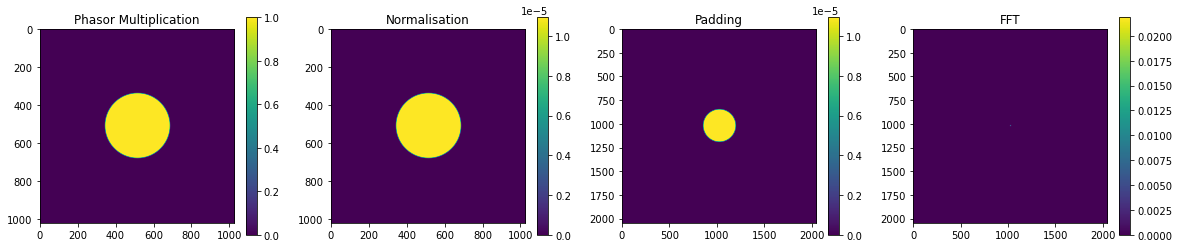

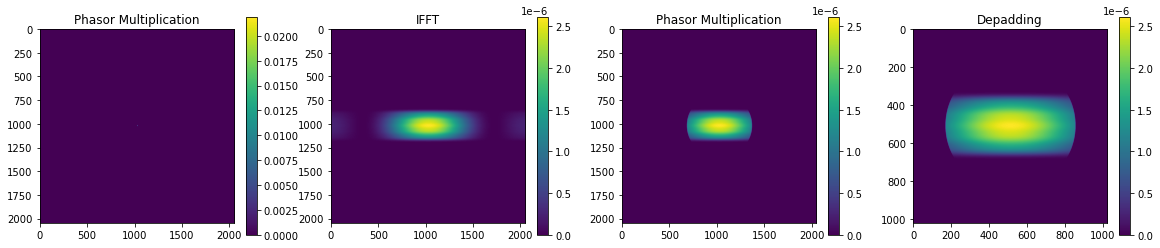

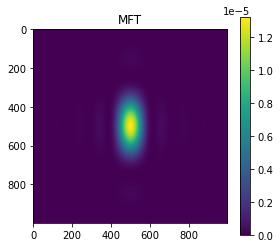

New wavelength!




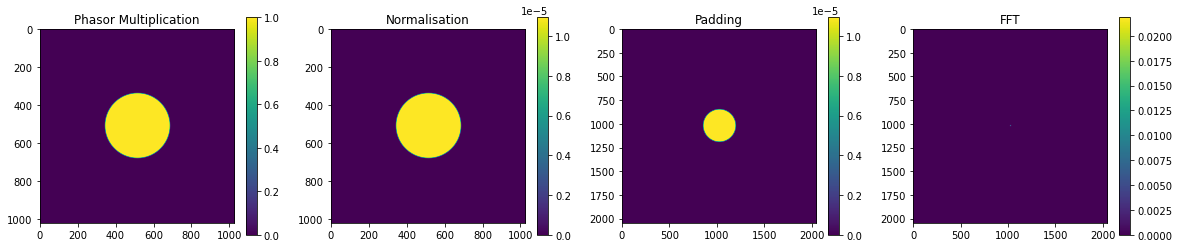

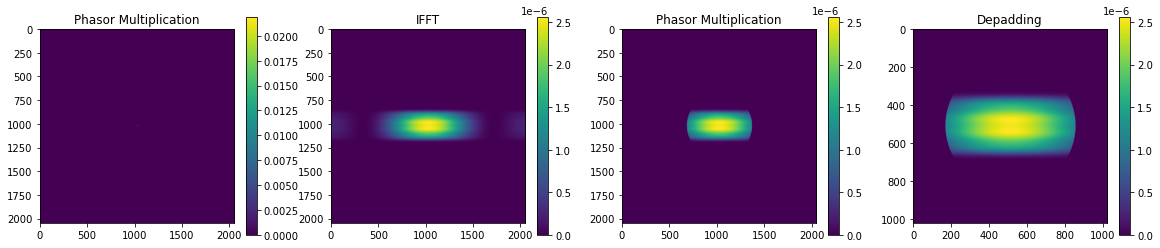

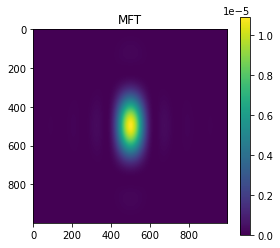

New wavelength!




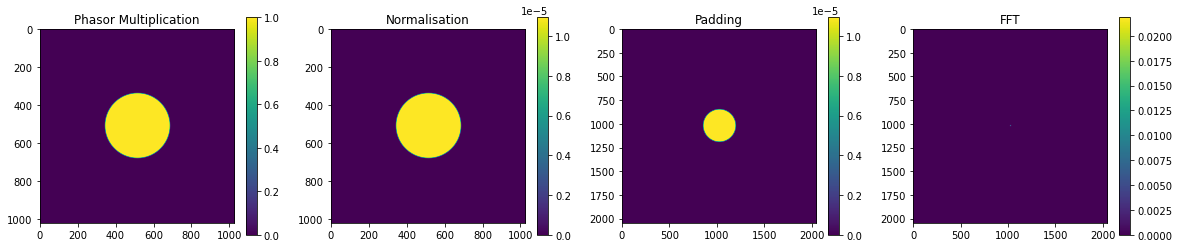

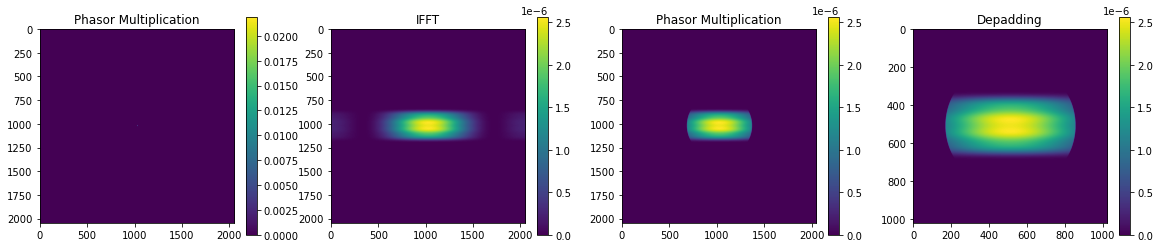

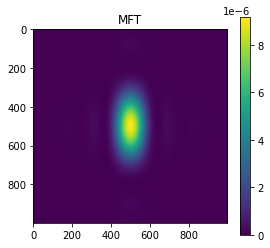

In [21]:
wavefronts_out, fig = [], None

for i in range(len(ops_out)):
    wavefront = create_wavefront(1024)
    
    print("New wavelength!\n\n")
    for j in range(len(ops)):
        func = ops_out[i][j][0]
        args = ops_out[i][j][1]
        
        wavefront = func(wavefront, args)
        
        if j%4 == 0:
            if fig is not None:
                plt.show()
            fig = plt.figure(figsize=(20, 4))
            fig_idx = 1
            
        plt.subplot(1, 4, fig_idx)
        plt.title(operations_list_out[i][j][0])
        plt.imshow(np.abs(wavefront)**2)
        plt.colorbar()
        fig_idx += 1
        
        
    plt.show()
    wavefronts_out.append(wavefront)

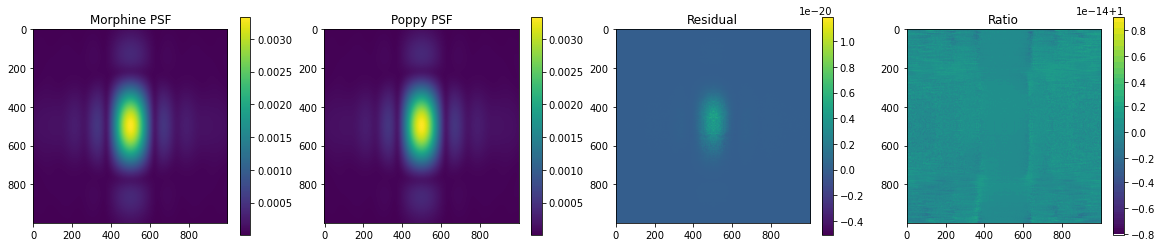

In [22]:
flux = 1.

poppy_psf = flux*fits_psf[0].data

morph_psfs_out = np.abs(np.array(wavefronts_out))**2
morph_psf = flux*np.sum(morph_psfs_out, axis=0)/len(morph_psfs_out)

plt.figure(figsize=(20, 4))
plt.subplot(1, 4, 1)
plt.imshow(morph_psf**0.5)
plt.title("Morphine PSF")
plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(poppy_psf**0.5)
plt.title("Poppy PSF")
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(poppy_psf - morph_psf)
plt.title("Residual")
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(poppy_psf/morph_psf)
# plt.imshow(np.log10(poppy_psf/morph_psf))
plt.title("Ratio")
plt.colorbar()
plt.show()

In [23]:
result = bool(np.allclose(poppy_psf, morph_psf))

if result is True:
    print("Yee Haaw!")
else:
    print("Better luck next time :'(")
    plt.imshow(np.isclose(poppy_psf, morph_psf))
    plt.colorbar()
    plt.show()

Yee Haaw!


---

## Osys 2

In [24]:
radius = 6.5/2
lyot_radius = 6.5/2.5
pixelscale = 0.060

osys = poppy.OpticalSystem("test", oversample=8)
osys.add_pupil( poppy.CircularAperture(radius=radius), name='Entrance Pupil')
osys.add_image( poppy.CircularOcculter(radius = 0.1) )
osys.add_pupil( poppy.CircularAperture(radius=lyot_radius), name='Lyot Pupil')
osys.add_detector(pixelscale=pixelscale, fov_arcsec=5.0)

In [25]:
min_wavel = 5e-6
max_wavel = 6e-6
nwavels = 3

wavels = np.linspace(min_wavel, max_wavel, nwavels)

In [26]:
fits_psf, operations_list_out = osys.calc_psf(wavels, compile_operations=True)
operations_list = operations_list_out[0]
for i in range(len(operations_list)):
    operation = operations_list[i][0]
    if operation == "Phasor Multiplication" or operation == "Array Multiplication":
        print(operations_list[i][0])
        print("args: some array")
    else:
        print(operations_list[i][0])
        print("args: {}".format(operations_list[i][1]))
    print()

Phasor Multiplication
args: some array

Normalisation
args: {}

Padding
args: {'shape': (1024, 1024), 'factor': 8}

FFT
args: {'shape': (8192, 8192)}

Phasor Multiplication
args: some array

IFFT
args: {'shape': (8192, 8192)}

Phasor Multiplication
args: some array

Depadding
args: {'shape': (8192, 8192), 'factor': 8}

MFT
args: {'nlamD': 31.38683771503136, 'npup': (1024, 1024), 'npix': 664.0}

Array Multiplication
args: some array



In [27]:
ops_out = []
static_args_list = []
dynamic_args_list = []
function_calls = []
for i in range(len(operations_list_out)):
    ops = []
    for j in range(len(operations_list_out[i])):
        operation = operations_list_out[i][j]
        key, vals_dict = operation[0], operation[1]

        func = function_dict[key]
        
        key, vals_dict = operation[0], operation[1]
        func = function_dict[key]
        if key == 'Initialise wavefront':
            pass
        elif key == 'Array Multiplication':
            args_in = vals_dict['array']
        elif key == 'Phasor Multiplication':
            args_in = vals_dict['phasor']
        elif key == 'Interpolation':
            raise NotImplementedError("{} is not Implemented".format(key))
        elif key == 'Normalisation':
            args_in = None
        elif key == 'Padding':
            args_in = vals_dict['shape'][0]*vals_dict['factor']
        elif key == 'Depadding':
            args_in = vals_dict['shape'][0]//vals_dict['factor']
        elif key == 'Rotation':
            args_in = vals_dict['angle']
        elif key == 'Invertion':
            args_in = vals_dict['axis']
        elif key == 'FFT':
            args_in = None
        elif key == 'IFFT':
            args_in = None
        elif key == 'MFT':
            args_in = [vals_dict['nlamD'], vals_dict['nlamD'], 0., 0., +1, vals_dict['npup'][0], vals_dict['npup'][1], vals_dict['npix'], vals_dict['npix']]
        elif key == 'IMFT':
            args_in = [vals_dict['nlamD'], vals_dict['nlamD'], 0., 0., +1, vals_dict['npup'][0], vals_dict['npup'][1], vals_dict['npix'], vals_dict['npix']]
        else:
            raise NotImplementedError("{} is not Implemented".format(key))


        ops.append([func, args_in])
    ops_out.append(ops)

New wavelength!




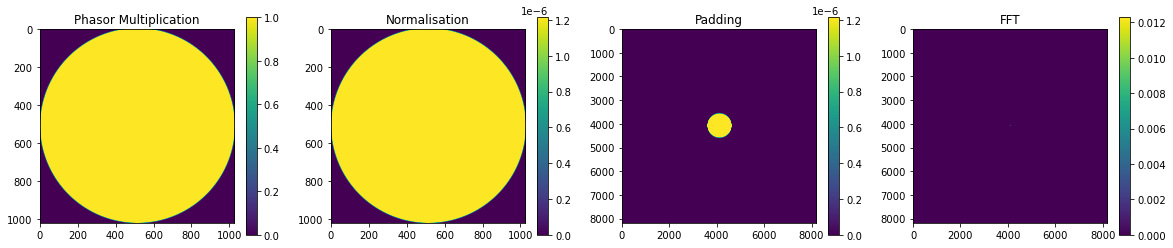

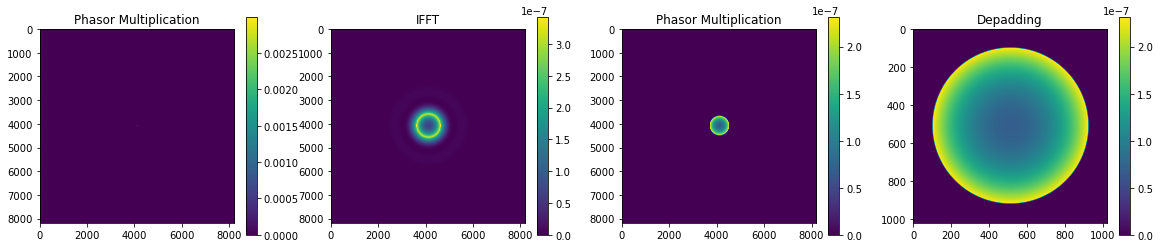

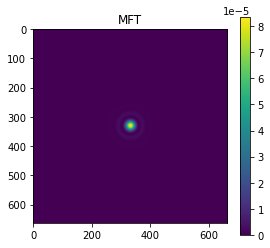

New wavelength!




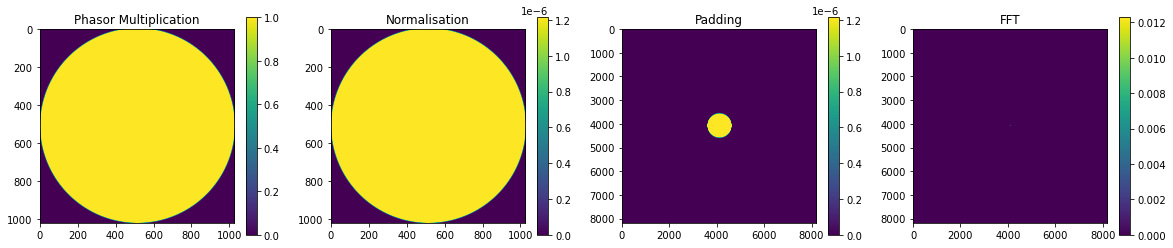

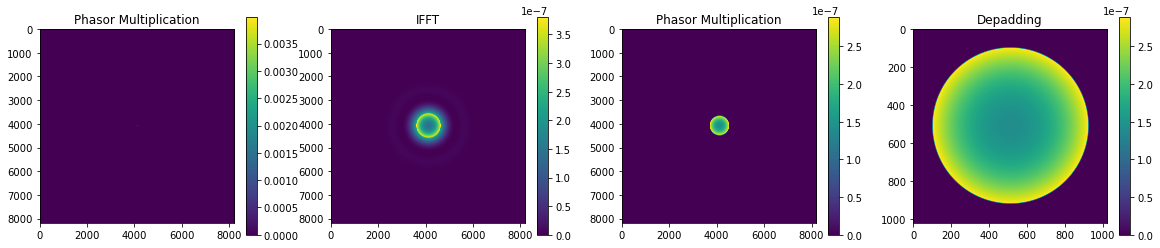

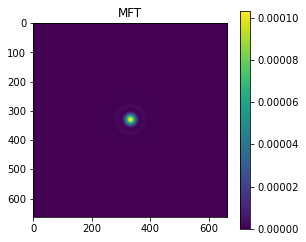

New wavelength!




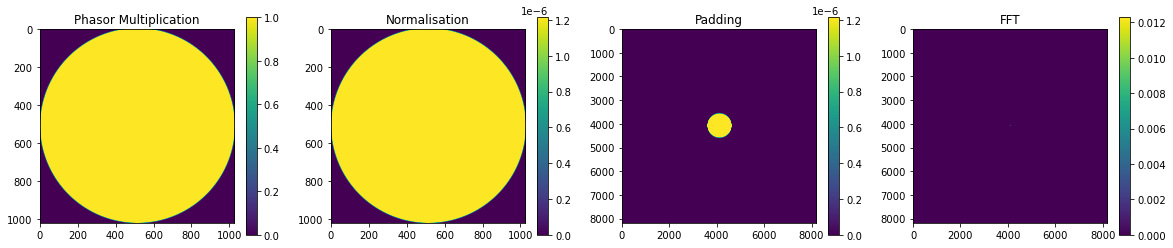

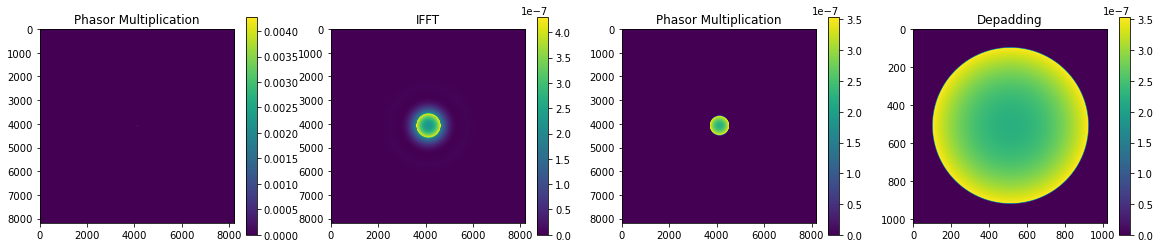

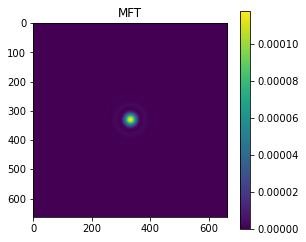

In [28]:
wavefronts_out, fig = [], None

for i in range(len(ops_out)):
    wavefront = create_wavefront(1024)
    
    print("New wavelength!\n\n")
    for j in range(len(ops)):
        func = ops_out[i][j][0]
        args = ops_out[i][j][1]
        
        wavefront = func(wavefront, args)
        
        if j%4 == 0:
            if fig is not None:
                plt.show()
            fig = plt.figure(figsize=(20, 4))
            fig_idx = 1
            
        plt.subplot(1, 4, fig_idx)
        plt.title(operations_list_out[i][j][0])
        plt.imshow(np.abs(wavefront)**2)
        plt.colorbar()
        fig_idx += 1
        
        
    plt.show()
    wavefronts_out.append(wavefront)

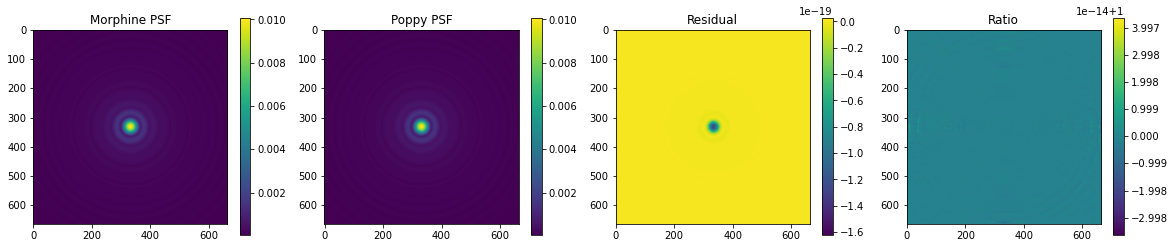

In [29]:
flux = 1.

poppy_psf = flux*fits_psf[0].data

morph_psfs_out = np.abs(np.array(wavefronts_out))**2
morph_psf = flux*np.sum(morph_psfs_out, axis=0)/len(morph_psfs_out)

plt.figure(figsize=(20, 4))
plt.subplot(1, 4, 1)
plt.imshow(morph_psf**0.5)
plt.title("Morphine PSF")
plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(poppy_psf**0.5)
plt.title("Poppy PSF")
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(poppy_psf - morph_psf)
plt.title("Residual")
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(poppy_psf/morph_psf)
# plt.imshow(np.log10(poppy_psf/morph_psf))
plt.title("Ratio")
plt.colorbar()
plt.show()

In [30]:
result = bool(np.allclose(poppy_psf, morph_psf))

if result is True:
    print("Yee Haaw!")
else:
    print("Better luck next time :'(")
    plt.imshow(np.isclose(poppy_psf, morph_psf))
    plt.colorbar()
    plt.show()

Yee Haaw!


---

## Osys 3

Note this doesnt give the exact result becuase there are other operations done in webbpsf, but these should be trivial to add

In [31]:
import webbpsf
osys = p.load(open("../NIRISS_osys.p", 'rb'))

In [32]:
min_wavel = 5e-6
max_wavel = 6e-6
nwavels = 3

wavels = np.linspace(min_wavel, max_wavel, nwavels)

In [33]:
fits_psf, operations_list_out = osys.calc_psf(wavels, compile_operations=True)
operations_list = operations_list_out[0]
for i in range(len(operations_list)):
    operation = operations_list[i][0]
    if operation == "Phasor Multiplication" or operation == "Array Multiplication":
        print(operations_list[i][0])
        print("args: some array")
    else:
        print(operations_list[i][0])
        print("args: {}".format(operations_list[i][1]))
    print()

Phasor Multiplication
args: some array

Normalisation
args: {}

Invertion
args: {'axis': 'y'}

Phasor Multiplication
args: some array

Phasor Multiplication
args: some array

MFT
args: {'nlamD': 12.600905979502688, 'npup': (1024, 1024), 'npix': 60.0}

Array Multiplication
args: some array



In [34]:
ops_out = []
static_args_list = []
dynamic_args_list = []
function_calls = []
for i in range(len(operations_list_out)):
    ops = []
    for j in range(len(operations_list_out[i])):
        operation = operations_list_out[i][j]
        key, vals_dict = operation[0], operation[1]

        func = function_dict[key]
        
        key, vals_dict = operation[0], operation[1]
        func = function_dict[key]
        if key == 'Initialise wavefront':
            pass
        elif key == 'Array Multiplication':
            args_in = vals_dict['array']
        elif key == 'Phasor Multiplication':
            args_in = vals_dict['phasor']
        elif key == 'Interpolation':
            raise NotImplementedError("{} is not Implemented".format(key))
        elif key == 'Normalisation':
            args_in = None
        elif key == 'Padding':
            args_in = vals_dict['shape'][0]*vals_dict['factor']
        elif key == 'Depadding':
            args_in = vals_dict['shape'][0]//vals_dict['factor']
        elif key == 'Rotation':
            args_in = vals_dict['angle']
        elif key == 'Invertion':
            args_in = vals_dict['axis']
        elif key == 'FFT':
            args_in = None
        elif key == 'IFFT':
            args_in = None
        elif key == 'MFT':
            args_in = [vals_dict['nlamD'], vals_dict['nlamD'], 0., 0., +1, vals_dict['npup'][0], vals_dict['npup'][1], vals_dict['npix'], vals_dict['npix']]
        elif key == 'IMFT':
            args_in = [vals_dict['nlamD'], vals_dict['nlamD'], 0., 0., +1, vals_dict['npup'][0], vals_dict['npup'][1], vals_dict['npix'], vals_dict['npix']]
        else:
            raise NotImplementedError("{} is not Implemented".format(key))


        ops.append([func, args_in])
    ops_out.append(ops)

New wavelength!




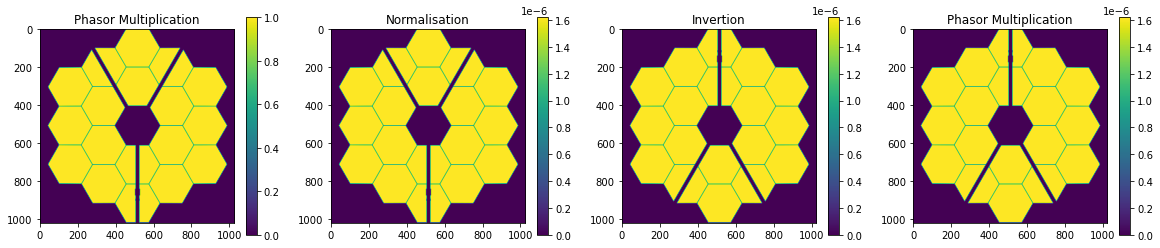

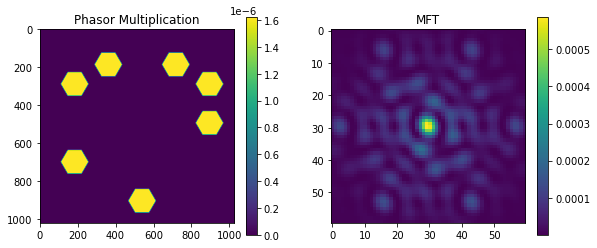

New wavelength!




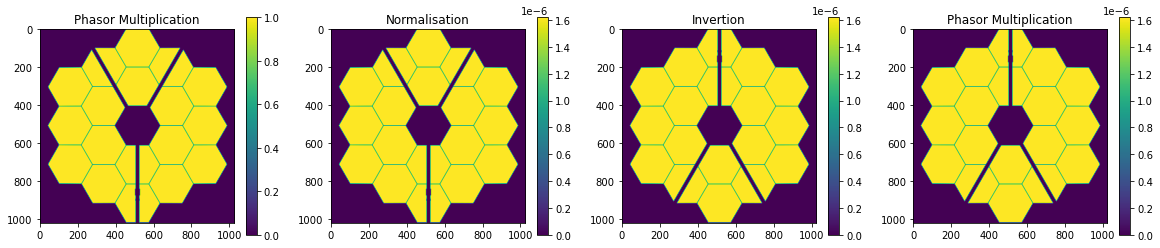

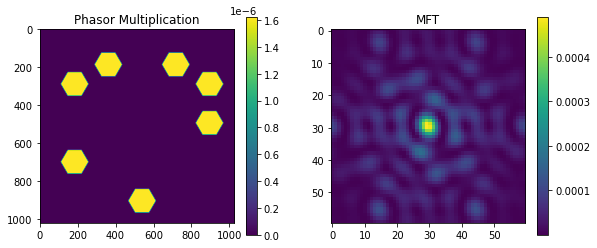

New wavelength!




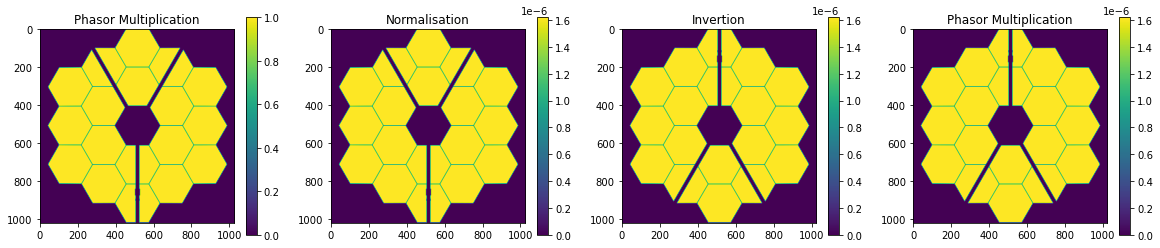

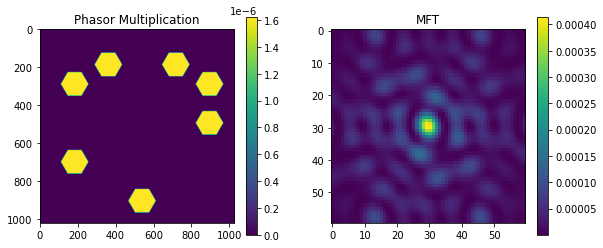

In [35]:
wavefronts_out, fig = [], None

for i in range(len(ops_out)):
    wavefront = create_wavefront(1024)
    
    print("New wavelength!\n\n")
    for j in range(len(ops)):
        func = ops_out[i][j][0]
        args = ops_out[i][j][1]
        
        wavefront = func(wavefront, args)
        
        if j%4 == 0:
            if fig is not None:
                plt.show()
            fig = plt.figure(figsize=(20, 4))
            fig_idx = 1
            
        plt.subplot(1, 4, fig_idx)
        plt.title(operations_list_out[i][j][0])
        plt.imshow(np.abs(wavefront)**2)
        plt.colorbar()
        fig_idx += 1
        
        
    plt.show()
    wavefronts_out.append(wavefront)

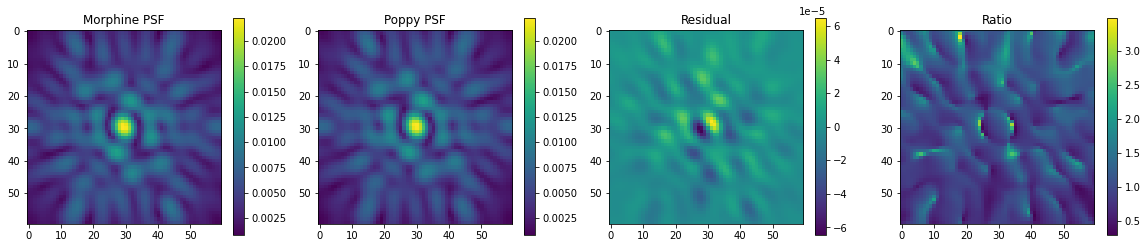

In [36]:
flux = 1.

poppy_psf = flux*fits_psf[0].data

morph_psfs_out = np.abs(np.array(wavefronts_out))**2
morph_psf = flux*np.sum(morph_psfs_out, axis=0)/len(morph_psfs_out)

plt.figure(figsize=(20, 4))
plt.subplot(1, 4, 1)
plt.imshow(morph_psf**0.5)
plt.title("Morphine PSF")
plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(poppy_psf**0.5)
plt.title("Poppy PSF")
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(poppy_psf - morph_psf)
plt.title("Residual")
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(poppy_psf/morph_psf)
# plt.imshow(np.log10(poppy_psf/morph_psf))
plt.title("Ratio")
plt.colorbar()
plt.show()

Better luck next time :'(


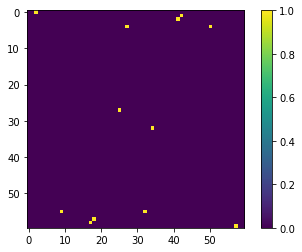

In [37]:
result = bool(np.allclose(poppy_psf, morph_psf))

if result is True:
    print("Yee Haaw!")
else:
    print("Better luck next time :'(")
    plt.imshow(np.isclose(poppy_psf, morph_psf))
    plt.colorbar()
    plt.show()